In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Conv1D,MaxPooling1D,Add,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
import shutil, os
import glob
from sklearn.model_selection import train_test_split
tweet_path='./data/preprocessed_tweet.csv'
train_path = './data/train.csv'
test_path = './data/test.csv'

In [2]:
training_data = pd.read_csv(train_path)
testing_data = pd.read_csv(test_path)

In [3]:
len(training_data )+len(testing_data )

19168

In [4]:
len(testing_data )

1917

In [5]:
hate,non_hate = training_data[training_data['label'] == 'negative' ].reset_index(drop=True) ,training_data[training_data['label'] != 'negative' ].reset_index(drop=True)

In [6]:
vocab_size = 256
sent_length=256

In [7]:
hate['one_hot'] = hate.apply(lambda row:one_hot(row.text  ,vocab_size) , axis = 1)
non_hate['one_hot'] = non_hate.apply(lambda row:one_hot(row.text  ,vocab_size) , axis = 1)
hate['one_hot']=list(pad_sequences(hate['one_hot'],padding='pre',maxlen=sent_length))
non_hate['one_hot']=list(pad_sequences(non_hate['one_hot'],padding='pre',maxlen=sent_length))

In [8]:
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

In [9]:
non_hate_val,non_hate_train = my_func(list(non_hate['one_hot'][:3000])) , my_func(list(non_hate['one_hot'][3000:]))

In [10]:
def generateModel(small_model,n):
    '''
    Utility function to generate a sample model for testing seprate network
    Input :- Fuction to generate seprate small network
    Output:- Sample model to test the data
    '''
    input_layer = keras.Input(shape=(None,),name="Input_Sentence")
    input_embeddings = layers.Embedding(vocab_size,64)(input_layer)
    x = small_model(input_embeddings)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)

    output = layers.Dense(256, activation="relu")(x)
    
    model = keras.Model(input_layer, output, name=n)
    model.compile(optimizer='adam',loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    return model

In [11]:
def inseptionNetwork(input_embeddings):
    '''
    2-layer inseption network generator function
    Input : Model till input embedding layer
    Output: Generated model till inseption network
    '''
    
    x1f = layers.Conv1D(8, 1, activation="relu", padding = "same")(input_embeddings)
    x2f = layers.Conv1D(16, 2, activation="relu", padding = "same")(input_embeddings)
    x3f = layers.Conv1D(32, 3, activation="relu", padding = "same")(input_embeddings)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(input_embeddings)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(input_embeddings)
    
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])
    x1f = layers.Conv1D(8, 1, activation="relu", padding = "same")(y)
    x2f = layers.Conv1D(16, 2, activation="relu", padding = "same")(y)
    x3f = layers.Conv1D(32, 3, activation="relu", padding = "same")(y)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(y)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(y)
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])
    
    y = layers.MaxPooling1D()(y)
    
    x1f = layers.Conv1D(8, 1, activation="relu", padding = "same")(y)
    x2f = layers.Conv1D(16, 2, activation="relu", padding = "same")(y)
    x3f = layers.Conv1D(32, 3, activation="relu", padding = "same")(y)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(y)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(y)
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])

    x1f = layers.Conv1D(8, 1, activation="relu", padding = "same")(y)
    x2f = layers.Conv1D(16, 2, activation="relu", padding = "same")(y)
    x3f = layers.Conv1D(32, 3, activation="relu", padding = "same")(y)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(y)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(y)
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])
    
    y = layers.GlobalMaxPooling1D()(y)
    
    return y

In [12]:
def resNet(input_embedding):
    x = layers.Conv1D(32, 3, activation="relu")(input_embedding)
    x = layers.Conv1D(64, 3, activation="relu")(x)
    block_1_output = layers.MaxPooling1D(3)(x)

    x = layers.Conv1D(32, 3, activation="relu", padding="same")(block_1_output)
    x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
    block_2_output = layers.add([x, block_1_output])

    x = layers.Conv1D(32, 3, activation="relu", padding="same")(block_2_output)
    x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
    block_3_output = layers.add([x, block_2_output])

    x = layers.Conv1D(64, 3, activation="relu")(block_3_output)
    x = layers.GlobalMaxPooling1D()(x)
    return x

In [13]:
def LSTMnetwork(input_embeddings):
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(input_embeddings)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    
    return x

In [14]:
def genall3(input_embeddings):
    gnet = inseptionNetwork2Layer(input_embeddings)
    resnet = resNet(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([gnet,resnet,lstm])
    return y

In [15]:
def gnet_lstm_v2(input_embeddings):
    gnet = inseptionNetwork(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([gnet,lstm])
    return y

In [16]:
def resnet_lstm(input_embeddings):
    resnet = resNet(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([resnet,lstm])
    return y

In [17]:
def prediction(model,path):
    model.load_weights(path)
    pred_non_hate = model.predict(non_hate_train)
    pred_hate = model.predict(my_func(list(hate['one_hot'])))
    return pred_non_hate,pred_hate

In [18]:
mini_google_model = generateModel(inseptionNetwork,'mini-google-net')   
path = './models/mini-google-model/checkpoint_epoch-18_rms-14.90.h5'

Model: "mini-google-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     16384       Input_Sentence[0][0]             
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 8)      520         embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 16)     2064        embedding[0][0]                  
____________________________________________________________________________________

In [19]:
pred_non_hate,pred_hate = prediction(mini_google_model,path)

In [20]:
pred_hate.shape

(3949, 256)

In [21]:
hate_val = my_func(list(hate['one_hot']))

In [22]:
hate_val[0].shape

TensorShape([256])

In [23]:
non_hate_rmse =[]
for i in range(len(non_hate_val)):
    diff_sq = np.sum((pred_non_hate[i]-non_hate_train[i])**2)
    non_hate_rmse.append((diff_sq**.5) / 256)

In [24]:
hate_rmse =[]
for i in range(len(non_hate_val)):
    diff_sq = np.sum((pred_hate[i]-hate_val[i])**2)
    hate_rmse.append((diff_sq**.5) / 256)

In [25]:
np.sum(hate_rmse)/len(hate_rmse)

0.751212892671235

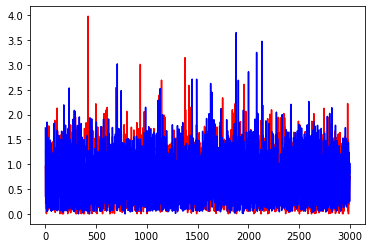

In [26]:
import matplotlib.pyplot as plt
plt.plot(non_hate_rmse,color = 'r')
plt.plot(hate_rmse,color = 'b')

plt.show()

In [27]:
def genall3(input_embeddings):
    gnet = inseptionNetwork(input_embeddings)
    resnet = resNet(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([gnet,resnet,lstm])
    return y

In [28]:
all3_model = generateModel(genall3,'all3')

Model: "all3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     16384       Input_Sentence[0][0]             
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, None, 32)     6176        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, None, 8)      520         embedding_1[0][0]                
_______________________________________________________________________________________________

In [29]:
def resNet(input_embedding):
    x = layers.Conv1D(32, 3, activation="relu")(input_embedding)
    x = layers.Conv1D(64, 3, activation="relu")(x)
    block_1_output = layers.MaxPooling1D(3)(x)

    x = layers.Conv1D(32, 3, activation="relu", padding="same")(block_1_output)
    x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
    block_2_output = layers.add([x, block_1_output])

    x = layers.Conv1D(32, 3, activation="relu", padding="same")(block_2_output)
    x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
    block_3_output = layers.add([x, block_2_output])

    x = layers.Conv1D(64, 3, activation="relu")(block_3_output)
    x = layers.GlobalMaxPooling1D()(x)
    return x

In [30]:
mini_residual_model = generateModel(resNet,'mini-resnet')
path = './models/mini-residual-model/checkpoint_epoch-20_rms-10.07.h5'

Model: "mini-resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     16384       Input_Sentence[0][0]             
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, None, 32)     6176        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, None, 64)     6208        conv1d_47[0][0]                  
________________________________________________________________________________________

In [36]:
hate_rmse =[]
for i in range(len(hate_val)):
    diff_sq = np.sum((pred_hate[i]-hate_val[i])**2)
    hate_rmse.append((diff_sq**.5) / 256)
non_hate_rmse =[]
for i in range(len(non_hate_val)):
    diff_sq = np.sum((pred_non_hate[i]-non_hate_train[i])**2)
    non_hate_rmse.append((diff_sq**.5) / 256)

In [39]:
np.sum(hate_rmse)/len(hate_rmse),np.sum(non_hate_rmse)/len(non_hate_rmse)

(0.7520294023140067, 0.7620343432980224)

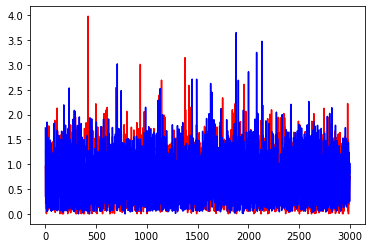

In [32]:
import matplotlib.pyplot as plt
plt.plot(non_hate_rmse,color = 'r')
plt.plot(hate_rmse,color = 'b')

plt.show()

In [33]:
def genall3(input_embeddings):
    gnet = inseptionNetwork(input_embeddings)
    resnet = resNet(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([gnet,resnet,lstm])
    return y

In [34]:
all3_model = generateModel(genall3,'all3')


Model: "all3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     16384       Input_Sentence[0][0]             
__________________________________________________________________________________________________
conv1d_74 (Conv1D)              (None, None, 32)     6176        embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_54 (Conv1D)              (None, None, 8)      520         embedding_3[0][0]                
_______________________________________________________________________________________________

In [40]:
path = './models/all3/checkpoint_epoch-20_rms-12.17.h5' 
pred_non_hate,pred_hate = prediction(all3_model ,path)

In [43]:
hate_rmse =[]
for i in range(len(non_hate_val)):
    diff_sq = np.sum((pred_hate[i]-hate_val[i])**2)
    hate_rmse.append((diff_sq**.5) / 256)
non_hate_rmse =[]
for i in range(len(non_hate_val)):
    diff_sq = np.sum((pred_non_hate[i]-non_hate_train[i])**2)
    non_hate_rmse.append((diff_sq**.5) / 256)

In [46]:
np.sum(hate_rmse)/len(hate_rmse),np.sum(non_hate_rmse)/len(non_hate_rmse)

(0.5429840750770913, 0.544267761868716)

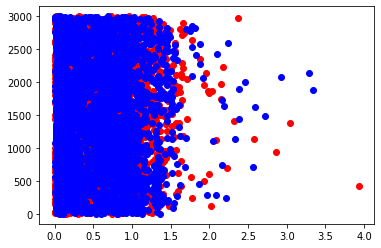

In [50]:
import matplotlib.pyplot as plt
plt.scatter(non_hate_rmse,[i for i in range(len(non_hate_rmse))],color = 'r')
plt.scatter(hate_rmse,[i for i in range(len(hate_rmse))],color = 'b')
plt.show()

In [45]:
sen='bhosdike chup'
sen=one_hot(sen ,vocab_size)
sen=pad_sequences([sen],padding='pre',maxlen=256)
# hate['one_hot'] = hate.apply(lambda row:one_hot(row.text  ,vocab_size) , axis = 1)
# non_hate['one_hot'] = non_hate.apply(lambda row:one_hot(row.text  ,vocab_size) , axis = 1)
# hate['one_hot']=list(pad_sequences(hate['one_hot'],padding='pre',maxlen=sent_length))
# non_hate['one_hot']=list(pad_sequences(non_hate['one_hot'],padding='pre',maxlen=sent_length))
sent=my_func(sen)
sent=all3_model.predict(sent)
print(sent)

[[  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.  

In [51]:
np.sum((sen[0]-sent[0])**2)/256

0.14866395579866776